<a href="https://colab.research.google.com/github/nikhilnimbalkar1/STS/blob/master/STSmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Siamese Manhattan LSTM-RNN for Semantic Similarity of Text. 
This architecture is based on [this keras model ](https://github.com/eliorc/Medium/blob/master/MaLSTM.ipynb) , you can also try any other implementations from [this link](https://github.com/nikhilnimbalkar1?tab=stars).Try enhancing the model individually and share all progress.

In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import os
import csv
import scipy
import tensorflow.keras.backend as K

Module required to save models in "h5" format

In [0]:
!pip3 install -q pyyaml h5py 

Import and export files to google Drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Ensure you have tensorflow api v2 isntalled or there are some issues with training the final model that are not yet certain.

In [4]:
tf.version

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.6/dist-packages/tensorflow/_api/v2/version/__init__.py'>

Load STS Dataset and clean up some values.

In [0]:
def load_sts_dataset():
  sts_dataset = tf.keras.utils.get_file(
      fname="Stsbenchmark.tar.gz",
      origin="http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz",
      extract=True)

  sts_dev = pd.read_table(
      os.path.join(os.path.dirname(sts_dataset), "stsbenchmark", "sts-dev.csv"),
      error_bad_lines=False,
      skip_blank_lines=True,
      usecols=[4, 5, 6],
      names=["sim", "sent_1", "sent_2"])

  sts_test = pd.read_table(
      os.path.join(
          os.path.dirname(sts_dataset), "stsbenchmark", "sts-test.csv"),
      error_bad_lines=False,
      quoting=csv.QUOTE_NONE,
      skip_blank_lines=True,
      usecols=[4, 5, 6],
      names=["sim", "sent_1", "sent_2"])

  sts_train = pd.read_table(
      os.path.join(
          os.path.dirname(sts_dataset), "stsbenchmark", "sts-train.csv"),
      error_bad_lines=False,
      quoting=csv.QUOTE_NONE,
      skip_blank_lines=True,
      usecols=[4, 5, 6],
      names=["sim", "sent_1", "sent_2"])
  # cleanup some NaN values in sts_dev
  sts_dev = sts_dev[[isinstance(s, str) for s in sts_dev['sent_2']]]
  return sts_train,sts_test,sts_dev



Load Universal Sentence Encoder transformer model.Alternatively we can use DAN model too. 

In [0]:
def load_USE():
  use_model_url="https://tfhub.dev/google/universal-sentence-encoder-large/5"
  embed=hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")
  return embed

Helper Function to calculate Manhattan Distance between the final output Tensors

In [0]:
def manhattan_distance(left, right):
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

Prepare Data and convert both sentences to embeddings seperately and convert the similarity column to Tensor type too.
Shuffling and Repeating the data from Tensorflow API should be used too to get accurate models.We'll try that individually and compare models later.

In [0]:
embed=load_USE()
def prepare_data(sts_data):
  sts_encode1 = tf.nn.l2_normalize(embed(tf.constant(sts_data['sent_1'].tolist())), axis=1)
  sts_encode2 = tf.nn.l2_normalize(embed(tf.constant(sts_data['sent_2'].tolist())), axis=1)
  sts_encode1=tf.expand_dims(sts_encode1,axis=2)
  sts_encode2=tf.expand_dims(sts_encode2,axis=2)
  sts_sims=sts_data['sim']
  sts_sims=tf.convert_to_tensor(sts_sims)
  #Normalise similarity score using Min-Max normalization as our output won't vary from 0 to 5
  sts_sims=tf.divide(tf.subtract(sts_sims,tf.reduce_min(sts_sims)),tf.subtract(tf.reduce_max(sts_sims),tf.reduce_min(sts_sims)))
  return sts_encode1,sts_encode2,sts_sims


Function to plot model loss and accuracy

In [0]:
def plot_model_history(model):
  # Plot loss
  plt.grid(b=True)
  plt.plot(model.history['loss'])
  plt.plot(model.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper right')
  plt.show()

Building model with appropriate data.

In [10]:
train,test,dev=load_sts_dataset()
train_embeddings1,train_embeddings2,train_similarity=prepare_data(train)


417792/409630 [==============================] - 4s 9us/step


The "sts_dev" dataset has some issues that need to be looked at but for now we can use test data for validation or use  "validation_split" parameter while training the final model to use some part of the training dataset for validation.

In [0]:
val_embeddings1,val_embeddings2,val_similarity=prepare_data(test)

# LSTM Model 

This is the input model to the final output.This will make our Siamese architecture.We need to enhance this model by adding different layers and check for overfitting and underfitting accordingly.Make changes to this model first and analyse accuracy and loss.
The last LSTM layer must have **"return_sequences=False"** as the next layer will not accept a 3D tensor. You can check the inputs of each layer by executing **model.summary()**.
LSTM layers must have a 3D input always.

In [0]:
lstm_model=tf.keras.Sequential([
                                tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,return_sequences=True)),
                                tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True)),
                                tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
                                tf.keras.layers.Dense(1,activation='relu')
])

Input shapes for the siamese model and output tensors from the LSTM model.

In [0]:
inp1=tf.keras.Input(shape=[512,1])
inp2=tf.keras.Input(shape=[512,1])
out1=lstm_model(inp1)
out2=lstm_model(inp2)

Calculating Manhattan Distance of the output Tensors.We may try a few different distance calcaulations too if required.

In [0]:
malstm_dist=tf.keras.layers.Lambda(function=lambda x: manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([out1, out2])

# Final Model
The final model takes the LSTM models as input and gives Manhattan Distance as Output. 

In [0]:
malstm = tf.keras.Model([inp1, inp2], [malstm_dist])

In [0]:
malstm.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.MeanSquaredError())

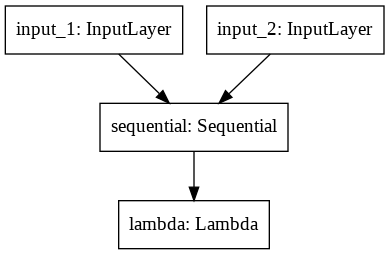

In [17]:
tf.keras.utils.plot_model(malstm)

In [18]:
malstm.summary()
lstm_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 1)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 512, 1)]     0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 512, 1)       1349249     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1, 1)         0           sequential[0][0]             

# Callbacks
Early Stopping callback to stop training if validation loss is not improving and ModelCheckpoint to save the best model during training. 

In [0]:
es=tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode="min",patience=3)
best_model_save=tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/STS_models/bestmodel.h5',monitor='val_loss',save_best_only=True,mode='min')

In [20]:
model_hist=malstm.fit([train_embeddings1,train_embeddings2],train_similarity,epochs=10,validation_data=([val_embeddings1,val_embeddings2],val_similarity),shuffle=True,batch_size=64,validation_batch_size=64,callbacks=[es,best_model_save],use_multiprocessing=True)

Epoch 1/10
90/90 [==============================] - 43s 483ms/step - loss: 0.0617 - val_loss: 0.0488
Epoch 2/10
90/90 [==============================] - 40s 447ms/step - loss: 0.0452 - val_loss: 0.0482
Epoch 3/10
90/90 [==============================] - 39s 433ms/step - loss: 0.0448 - val_loss: 0.0482
Epoch 4/10
90/90 [==============================] - 39s 436ms/step - loss: 0.0447 - val_loss: 0.0483
Epoch 5/10
90/90 [==============================] - 39s 434ms/step - loss: 0.0451 - val_loss: 0.0486


Loss may vary a bit for each training session.Approximate MSE value for validation is 0.0481.Best was 0.0431. 

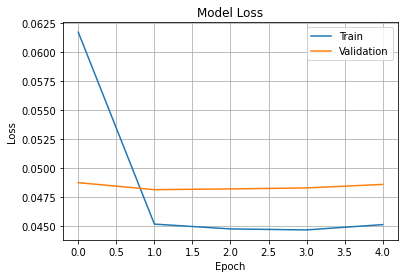

In [25]:
plot_model_history(model_hist)

In [0]:
def create_embeddings(sentence):
    embedding = tf.nn.l2_normalize(embed(sentence), axis=1)
    embedding=tf.expand_dims(embedding,axis=2)
    return embedding

# Prediction
Function returns the provided dataset appended with a column containing predicted values by our model.

In [0]:
def predict_samples(samples,model):
  samples_embeddings1,samples_embeddings2,samples_similarity=prepare_data(samples)
  preds=model.predict([samples_embeddings1,samples_embeddings2])
  preds=preds*5
  preds=preds.tolist()
  preds=pd.DataFrame(preds)
  samples['predicted_sim']=preds
  return samples


Predicting first 100 samples from the 'dev' set of STS.

In [30]:
predicted_data=predict_samples(dev[:100],malstm)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Save predicted data to drive.
Change paths to save file as you prefer.

In [0]:
predicted_data.to_csv('/content/gdrive/My Drive/Colab Notebooks/Datasets_STS/predicted_data_sts.csv')